<a href="https://colab.research.google.com/github/vineethvc/googleColab/blob/main/TwitterUnderstanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and install spacy language pack for English. Running in colab requires the runtime to be restarted after downloading the package

In [ ]:
!python -m spacy download en_core_web_lg


Install Tweepy package for accessing twitter APIs

In [ ]:
!pip install tweepy
!pip install emoji --upgrade
!pip install pyldavis
!pip install gensim
!pip install chart_studio
!pip install --upgrade autopep8

In [2]:
import tweepy
import pandas as pd
import numpy as np
import os, csv, logging, urllib, urllib3, json,bson, re,string
from bson import json_util
from datetime import datetime, timedelta
from datetime import time
import collections ,sys,math, time, datetime


Tokens for connections that need to be used for accessing the tweets. Twitter account is accessed using the following four credentials.

In [3]:
def auth_credentails_withoutJSONParser():

  CONSUMER_TOKEN="*************************"
  CONSUMER_SECRET="**************************************************"
  # set access token and secret
  access_token ="*********-****************************************"
  access_token_secret="*********************************************"
  #Authentication for api
  auth=tweepy.OAuthHandler(CONSUMER_TOKEN,CONSUMER_SECRET)
  auth.set_access_token(access_token, access_token_secret)
  #API to authenticate the credentails
  try:
    api=tweepy.API(auth,wait_on_rate_limit=True)
    return api
  except BaseException as e:
    print("Authentication has been failed due to — "+str(e))

A dataframe to store the information about tweets that are retrieved

In [4]:
def df_loadcolumns(): 
	df = pd.DataFrame(columns=['UId', 'UFullName', 'UScreenName','UCTweet','UHashtags', 'Uusermentions', 'QTId', 'QTFullName', 'QTScreenName', 'QTFTweet', 'Topic'])
	return df

Use Tweepy cursor options to search for tweets with hashtags matching the search string. Extract tweet text for analysis

Get the tweets favourited by a user to collect text data of the tweets liked by them. The retrieved JSON result is searched for entities like hashtags, user mentions, screen name and tweet text

In [5]:
api=auth_credentails_withoutJSONParser()
df = df_loadcolumns()
df.empty
# collect all the hashtags in tweets
hashtags = []
# collect all mentioned user in tweets
mentions = []
ictr=0
print('enter')
for status in tweepy.Cursor(api.favorites, id = 'vindi_cfc', tweet_mode = 'extended').pages(40):
  #print(status)
  
  for search in status:
    uhashtags=""
    user_mentions=""
    if hasattr(search, "entities"):
      entities = search.entities
      if "hashtags" in entities:
        for ent in entities["hashtags"]:
          if ent is not None:
            if "text" in ent:
              hashtag = ent["text"]
              if hashtag is not None:
                uhashtags += " #"+hashtag
    if "user_mentions" in entities:
      for ent in entities["user_mentions"]:
        if ent is not None:
          if "screen_name" in ent:
            name = ent["screen_name"]
          if name is not None:
            user_mentions +=name+", "
            mentions.append(name)
    if hasattr(search, "quoted_status"):
      full_text=''
      if 'full_text' in search._json['quoted_status']:
        full_text=search._json['quoted_status']['full_text']
        df= df.append({'UId':str(search._json['user']['id_str']), 'UFullName':str(search._json['user']['name']), 'UScreenName':str(search._json['user']['screen_name']), 'UCTweet':search._json['full_text'],'UHashtags':uhashtags, 'Uusermentions':user_mentions,'QTId':str(search._json['quoted_status']['user']['id_str']), 'QTFullName':str(search._json['quoted_status']['user']['name']), 'QTScreenName':str(search._json['quoted_status']['user']['screen_name']), 'QTFTweet':str(search._json['quoted_status']['full_text'])},ignore_index=True)

    else:
      df= df.append({'UId':str(search._json['user']['id_str']), 'UFullName':str(search._json['user']['name']), 'UScreenName':str(search._json['user']['screen_name']), 'UCTweet':search._json['full_text'],'UHashtags':uhashtags, 'Uusermentions':user_mentions},ignore_index=True)
    
    # if hasattr(search, "full_text"):
    #   #print(entities)
    #   text = search.full_text
    #   print(text)
    # if hasattr(search, "quoted_status"):
    #   text2 = search.quoted_status.full_text
    #   print(text2)
    # if hasattr(search, "user"):
    #   name = search.user.name
    #   screenName = search.user.screen_name
    #   print(name+" "+screenName)

enter


Create a new dataframe containing tweets and indexing for better text analysis

In [ ]:
data_text = df[['UCTweet']]
data_text['index'] = data_text.index

In [ ]:
documents = data_text

Data cleaning methods

In [ ]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

Clear emojis and URL links

In [ ]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
documents['emoji_free_tweets'] = documents['UCTweet'].apply(call_emoji_free)

#Create a new column with url free tweets
documents['url_free_tweets'] = documents['emoji_free_tweets'].apply(url_free_text)

In [12]:
nlp = spacy.load('en_core_web_lg')

Tokenize the text using Spacy tokenizer and custom stopwords

In [ ]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(documents['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
documents['tokens'] = tokens

Lemmatize the token words, by reducing the word to their root form

In [ ]:
# Make tokens a string again
documents['tokens_back_to_text'] = [' '.join(map(str, l)) for l in documents['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

documents['lemmas'] = documents['tokens_back_to_text'].apply(get_lemmas)

Clean up the text using regex patterns

In [ ]:
# Make lemmas a string again
documents['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in documents['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    #tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub(r"\d", "", text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',')
    tokens = tokens.strip('?')
    tokens = tokens.strip('!')
    tokens = tokens.strip("'")
    tokens = tokens.strip(".")

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
documents['lemma_tokens'] = documents['lemmas_back_to_text'].apply(tokenize)

In [ ]:
# Create a id2word dictionary
id2word = Dictionary(documents['lemma_tokens'])
print(len(id2word))

Remove tokens which appear in less than 2 documents and that appear more than 99% of the tokens

In [ ]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

In [85]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in documents['lemma_tokens']]

In [ ]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=10)

In [87]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [88]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [89]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
blue chelseafc cfc game fan home arsenal club champion day

------ Topic 1 ------
chelsea come india win take fan day join l second

------ Topic 2 ------
man istanbul thank player time leipzig play right place moment

------ Topic 3 ------
1 goal score chelsea league giroud 3 ucl game 0

------ Topic 4 ------
year chelsea season good team pl game watch play win



Create a Frequency distribution of most commonly occuring words

In [90]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in documents['tokens'] for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)

[('chelsea', 55),
 ('league', 40),
 ('goals', 36),
 ('#cfc', 32),
 ('scored', 29),
 ('1', 24),
 ('champions', 22),
 ('#ucl', 22),
 ('giroud', 22),
 ('team', 21),
 ('premier', 21),
 ('game', 20),
 ('goal', 20),
 ('@chelseafc', 20),
 ('man', 19),
 ('thank', 19),
 ('3', 17),
 ('player', 16),
 ('#chelee', 16),
 ('olivier', 16),
 ('home', 15),
 ('players', 14),
 ('best', 14),
 ('|', 14),
 ('time', 14),
 ('4', 14),
 ('leeds', 14),
 ('happy', 13),
 ('india', 13),
 ('pl', 13)]

In [91]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

Create a visual representation of commonly occuring word. The bigger the words the more frequent they appear in the text corpus.

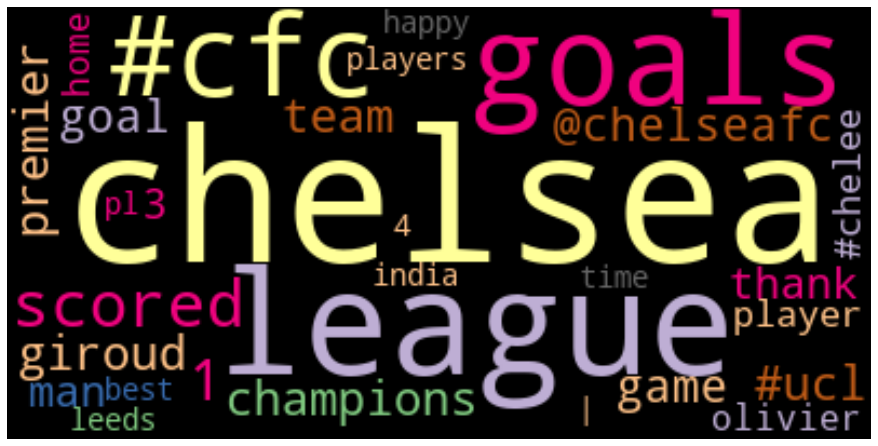

In [92]:
from wordcloud import WordCloud

#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black').generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')

plt.show()

Visualize the distance between topics. The right side shows the words that make up the topic

In [93]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.201526 -0.027558       1        1  32.781284
4     -0.028925  0.019041       2        1  22.751996
2     -0.062897 -0.089610       3        1  15.216615
1     -0.081066 -0.062535       4        1  14.872883
0     -0.028638  0.160662       5        1  14.377221, topic_info=        Term       Freq      Total Category  logprob  loglift
126        1  52.000000  52.000000  Default  30.0000  30.0000
28      goal  56.000000  56.000000  Default  29.0000  29.0000
31     score  37.000000  37.000000  Default  28.0000  28.0000
332   giroud  27.000000  27.000000  Default  27.0000  27.0000
203     come  18.000000  18.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
317    mount   3.290760   8.337356   Topic5  -5.1445   1.0099
401  amazing   3.034241   6.690050   Topic5  -5.2256   1.1489
478   family   3.294650  10.706616   Topic5  -5.1433   0.7610
166     year   3.602017  24.004047   Topic5  -5.0541   0.0428
47    season   3.293687  30.257742   Topic5  -5.1436  -0.2782

[332 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
125       1  0.848819       0
125       2  0.049931       0
125       4  0.049931       0
126       1  0.965156       1
126       3  0.018925       1
...     ...       ...     ...
166       5  0.166639    year
626       4  0.828565  zlatan
333       1  0.769239   zouma
333       2  0.192310   zouma
49        5  0.736834       ◉

[524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=documents['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)